In [1]:
import pandas as pd
import sklearn
from tqdm import tqdm
import numpy as np
import nltk
from nltk.corpus import stopwords
from torch import nn
from torch.optim import Adam
import torch

In [2]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# Dataset
# repository https://github.com/iresiragusa/NLP/tree/main
# https://www.kaggle.com/datasets/yufengdev/bbc-fulltext-and-category?select=bbc-text.csv
# scarichiamo il dataset e lo carichiamo su COLAB

root = "/content/gdrive/MyDrive/Colab Notebooks/torch/"
df = pd.read_csv(root+"data/BBC-text/bbc-text.csv")
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [6]:
# il dataset è formato da 2225 sample contenenti aricoli della BBC
# suddivisi in 5 categorie in base al loro topic

print('n sample -> '+str(len(df)))
labels = set(df['category'])
print('categories -> '+str(labels)+'['+str(len(labels))+']')
print(df['category'].value_counts())
#df.groupby(['category']).size().plot.bar()

n sample -> 2225
categories -> {'entertainment', 'business', 'sport', 'tech', 'politics'}[5]
category
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: count, dtype: int64


In [7]:
# associo ad ogni categoria un indice, così ho delle label numeriche
labels_dict = {
    'business': 0,
    'politics': 1,
    'tech': 2,
    'sport': 3,
    'entertainment': 4
}

df['labels'] = df.apply(lambda row: labels_dict[row.category], axis = 1)

df['labels']

,labels
0,2
1,0
2,3
3,3
4,4
...,...
2220,0
2221,1
2222,4
2223,1


In [8]:
from sklearn.model_selection import train_test_split

(x_train, x_test, y_train, y_test) = train_test_split(
    df['text'], df['labels'], test_size=0.2, random_state=17)

(x_train, x_val, y_train, y_val) = train_test_split(
    x_train, y_train, test_size=0.1, random_state=17)

# sarebbe uno split 72, 8, 20 per avere lo stesso test dell'altra volta

In [9]:
print(len(x_train))
print(len(x_val))
print(len(x_test))

1602
178
445


In [20]:
nltk.download('punkt')
nltk.download('stopwords')

class Dataset(torch.utils.data.Dataset):

    def __init__(self, x, y, stopwords):

        # x e y sono series di pandas
        tokens_litt = [nltk.word_tokenize(text, language='english') for text in list(x)]
        text_clean = []

        if stopwords:
            for sentence in tqdm(tokens_litt, desc='Tokenizing ... '):
                text_clean.append(' '.join([w.lower() for w in sentence if not w.lower() in nltk.corpus.stopwords.words("english")]))
        else:
            for sentence in tqdm(tokens_litt, desc='Tokenizing ... '):
                text_clean.append(' '.join([w.lower() for w in sentence]))
            # ogni token è separato dall'altro con uno spazio

        self.texts = text_clean
        self.labels = [torch.tensor(label) for label in y]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):

        batch_texts = self.texts[idx]
        batch_labels = np.array(self.labels[idx])

        return batch_texts, batch_labels

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
hyperparameters = {
    "epochs": 5,
    "learning_rate": 1e-3,
    "batch_size": 64,
    "dropout": 0.1,
    "stopwords": False,
    "layers": 1,
    "h_dim": 300,
    "bilstm": True,
    "patience": 5,
    "min_delta": 0.01
}

In [22]:
#creo i dataset

train_dataset = Dataset(x_train, y_train, hyperparameters["stopwords"])
val_dataset = Dataset(x_val, y_val, hyperparameters["stopwords"])
test_dataset = Dataset(x_test, y_test, hyperparameters["stopwords"])

Tokenizing ... : 100%|██████████| 445/445 [00:00<00:00, 13147.27it/s]


In [23]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle= True)
for x,y in train_dataloader:
#for x,y in train_dataset:
    print(x)
    print(y)
    break

('parmalat boasts doubled profits parmalat the italian food group at the centre of one of europe s most painful corporate scandals has reported a doubling in profit . its pre-tax earnings in the fourth quarter were 77m euros ( £53m ; $ 100m ) up from 38m in the same period of 2003. less welcome was the news that the firm had been fined 11m euros for having violated takeover rules five years ago . the firm sought bankruptcy protection in december 2003 after disclosing a 4bn-euro hole in its accounts . overall the company s debt is close to 12bn euros and is falling only slowly . its brands well-known in italy and overseas have continued to perform strongly however and have barely lost revenue since the scandal broke . but a crucial factor for the company s future is the legal unwinding of its intensely complex financial position . on tuesday the company s administrator turnaround expert enrico bondi sued morgan stanley its former banker to return 136m euros relating to a 2003 bond deal 

In [25]:
# ho solo i testi
print(list(x_train)[0])
print(type(list(x_train)[0]))

# ho una tupla test+label
print(train_dataset[0])
print(type(train_dataset[0]))

halo fans  hope for sequel xbox video game halo 2 has been released in the us on 9 november  with a uk release two days later. why is the game among the most anticipated of all time   halo is considered by many video game pundits to be one of the finest examples of interactive entertainment ever produced and more than 1.5 million people worldwide have pre-ordered the sequel. a science fiction epic  halo centred the action on a human cyborg  controlled by the player  who had to save his crew from an alien horde after a crash landing on a strange and exotic world contained on the interior surface of a giant ring in space. remembrance of things past it was not - but as a slice of schlock science fiction inspired by works such as larry niven s ringworld and the film starship troopers  it fit the bill perfectly. halo stood out from a crowd of similar titles - it was graphically impressive  had tremendous audio  using dolby digital  a decent storyline  instant playability and impressive phys

In [27]:
class EmbsLSTMClassifierDeep(nn.Module):

    def __init__(self, labels, lstm_layers, lstm_hdim, bilstm, dropout):
        super(EmbsLSTMClassifierDeep, self).__init__()
        self.lstm = nn.LSTM(lstm_hdim, lstm_hdim, lstm_layers,
            bidirectional=bilstm, batch_first=True)
        if bilstm:
            lstm_output = lstm_hdim*2
        else :
            lstm_output = lstm_hdim
        self.bilstm = bilstm
        self.classifier = nn.Sequential(
            nn.Linear(lstm_output, lstm_output),
            nn.BatchNorm1d(lstm_output),
            nn.Dropout(dropout),
            nn.ReLU(),
            nn.Linear(lstm_output, labels),
            )
        # non ho funzione di attivazione, è embedded nella loss
        # se devo calcolare l'accuracy, devo applicare una softmax/logsoftmax manualmente

    # parametri e output della LSMT -> https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
    def forward(self, input_texts):
        _output, (hn, _cn) = self.lstm(input_texts)
        if not self.bilstm:
            lstm_output = hn[-1,:,:]
        else:
            lstm_output = torch.cat((hn[-2,:,:], hn[-1,:,:]), dim=1)
        final = self.classifier(lstm_output)
        return final

In [28]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0):

        self.patience = patience
        self.min_delta = min_delta              # valore minimo di decrescita della loss di validazione all'epoca corrente
                                                # per asserire che c'è un miglioramenti della loss
        self.counter = 0                        # contatore delle epoche di pazienza
        self.early_stop = False                 # flag di early stop
        self.min_validation_loss = torch.inf    # valore corrente ottimo della loss di validazione

    def __call__(self, validation_loss):
        # chiamata in forma funzionale dell'oggetto di classe EarlySopping

        if (validation_loss + self.min_delta) >= self.min_validation_loss:  # la loss di validazione non decresce
            self.counter += 1                                               # incrementiamo il contatore delle epoche di pazienza
            if self.counter >= self.patience:
                self.early_stop = True
                print("Early stop!")
        else:                                               # c'è un miglioramento della loss:
            self.min_validation_loss = validation_loss      # consideriamo la loss corrente
                                                            # come nuova loss ottimale
            self.counter = 0                                # e azzeriamo il contatore di pazienza


In [29]:
import csv

def load_glove():
    glove_path = root+"wordvectors/glove.6B.300d.txt"
    print("Loading glove vectors ...")
    with open(glove_path, encoding='utf-8') as f:
        reader = csv.reader(f, delimiter=' ', quoting=csv.QUOTE_NONE)
        model = {line[0]: np.array(list(map(float, line[1:])))
                for line in reader}
    print("Glove vectors loaded")
    return model

In [30]:
def gen_embeddings_glove(tokens, glove_embeddings):
    embeddings = []
    for sentence in tokens:
        emb = []
        for word in sentence:
            if word in glove_embeddings:
                emb.append(torch.tensor(glove_embeddings.get(word)))
        embeddings.append(torch.stack(emb))
    return embeddings

# serve per il padding
def get_max_len(embeddings):
    max_len = 0
    for e in embeddings:
        if e.shape[0] > max_len: max_len = e.shape[0]
    return max_len

In [31]:
def train_loop(model, dataloader, glove, loss, optimizer, device):
    model.train()

    epoch_acc = 0
    epoch_loss = 0

    for batch_texts, batch_labels in tqdm(dataloader, desc='training set'):

        optimizer.zero_grad()

        tokens = [nltk.word_tokenize(text, language='english') for text in list(batch_texts)]
        embeddings = gen_embeddings_glove(tokens, glove)
        max_len_batch = get_max_len(embeddings)
        input_embeddings =  torch.stack([torch.nn.functional.pad(x,(0,0,0, max_len_batch-x.shape[0])) for x in embeddings]).float().to(device)
        batch_labels = batch_labels.to(device)
        output = model(input_embeddings)

        # la loss è una CrossEntropyLoss, al suo interno ha la logsoftmax + negative log likelihood loss
        batch_loss = loss(output, batch_labels)
        batch_loss.backward()
        optimizer.step()

        epoch_loss += batch_loss.item()

        # per calcolare l'accuracy devo generare le predizioni applicando manualmente la logsoftmax
        softmax = nn.LogSoftmax(dim=1)
        epoch_acc += (softmax(output).argmax(dim=1) == batch_labels).sum().item()

        batch_labels = batch_labels.detach().cpu()
        input_embeddings = input_embeddings.detach().cpu()
        output = output.detach().cpu()

    return epoch_loss/len(dataloader), epoch_acc

In [32]:
def test_loop(model, dataloader, glove, loss, device):
    model.eval()

    epoch_acc = 0
    epoch_loss = 0

    with torch.no_grad():

        for batch_texts, batch_labels, in tqdm(dataloader, desc='dev set'):

            tokens = [nltk.word_tokenize(text, language='english') for text in list(batch_texts)]
            embeddings = gen_embeddings_glove(tokens, glove)
            max_len_batch = get_max_len(embeddings)
            input_embeddings =  torch.stack([torch.nn.functional.pad(x, (0,0,0, max_len_batch-x.shape[0])) for x in embeddings]).float().to(device)
            batch_labels = batch_labels.to(device)
            output = model(input_embeddings)

            # la loss è una CrossEntropyLoss, al suo interno ha la logsoftmax + negative log likelihood loss
            batch_loss = loss(output, batch_labels)
            epoch_loss += batch_loss.item()

            # per calcolare l'accuracy devo generare le predizioni applicando manualmente la logsoftmax
            softmax = nn.LogSoftmax(dim=1)
            epoch_acc += (softmax(output).argmax(dim=1) == batch_labels).sum().item()

            batch_labels = batch_labels.detach().cpu()
            input_embeddings = input_embeddings.detach().cpu()
            output = output.detach().cpu()

    return epoch_loss/len(dataloader), epoch_acc

In [33]:
def train_test(model,
               epochs,
               optimizer,
               device,
               train_data,
               test_data,
               batch_size,
               train_loss_fn,
               test_loss_fn=None,         # non necessariamente train e test loss devono differire
               early_stopping=None,       # posso addstrare senza early stopping
               val_data=None,             # e in questo caso non c'è validation set
               scheduler=None):           # possibile scheduler per monitorare l'andamento di un iperparametro,
                                          # tipicamente il learning rate

    train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
    test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

    # check sulle funzioni di loss
    if test_loss_fn == None:
        test_loss_fn = train_loss_fn

    # liste dei valori di loss e accuracy epoca per epoca per il plot
    train_loss = []
    validation_loss = []
    test_loss = []

    train_acc = []
    validation_acc = []
    test_acc = []

    glove = load_glove()

    # Ciclo di addestramento con early stopping
    for epoch in tqdm(range(1,epochs+1)):

        epoch_train_loss, epoch_train_acc = train_loop(model,
                    train_dataloader, glove, train_loss_fn, optimizer, device)
        train_loss.append(epoch_train_loss)
        train_acc.append(epoch_train_acc/len(train_data))

        # validation se è presente la callback di early stopping
        if early_stopping != None:
                epoch_validate_loss, epoch_validate_acc = test_loop(model,
                                val_dataloader, glove, test_loss_fn, device)
                validation_loss.append(epoch_validate_loss)
                validation_acc.append(epoch_validate_acc/len(val_data))

        # test
        epoch_test_loss, epoch_test_acc,= test_loop(model,
                                test_dataloader, glove, test_loss_fn, device)
        test_loss.append(epoch_test_loss)
        test_acc.append(epoch_test_acc/len(test_data))

        val_loss_str = f'Validation loss: {epoch_validate_loss:6.4f} ' if early_stopping != None else ' '
        val_acc_str = f'Validation accuracy: {(epoch_validate_acc/len(val_data)):6.4f} ' if early_stopping != None else ' '
        print(f"\nTrain loss: {epoch_train_loss:6.4f} {val_loss_str}Test loss: {epoch_test_loss:6.4f}")
        print(f"Train accuracy: {(epoch_train_acc/len(train_data)):6.4f} {val_acc_str}Test accuracy: {(epoch_test_acc/len(test_data)):6.4f}")

        # early stopping
        if early_stopping != None:
                early_stopping(epoch_validate_loss)
                if early_stopping.early_stop:
                    break

    return train_loss, validation_loss, test_loss, train_acc, validation_acc, test_acc

In [34]:
# Acquisiamo il device su cui effettueremo il training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

model = EmbsLSTMClassifierDeep(len(labels_dict),
                               hyperparameters["layers"],
                               hyperparameters["h_dim"],
                               hyperparameters["bilstm"],
                               hyperparameters["dropout"]).to(device)
print(model)

# Calcoliamo il numero totale dei parametri del modello
total_params = sum(p.numel() for p in model.parameters())
print(f"Numbero totale dei parametri: {total_params}")

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=hyperparameters["learning_rate"])

# Creiamo la callback di early stopping da passare al nostro metodo di addestramento
early_stopping = EarlyStopping(patience=hyperparameters['patience'],
                               min_delta=hyperparameters['min_delta'])


Using cuda device
EmbsLSTMClassifierDeep(
  (lstm): LSTM(300, 300, batch_first=True, bidirectional=True)
  (classifier): Sequential(
    (0): Linear(in_features=600, out_features=600, bias=True)
    (1): BatchNorm1d(600, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.1, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=600, out_features=5, bias=True)
  )
)
Numbero totale dei parametri: 1809605


In [35]:
# Routine di addestramento
train_loss, validation_loss,test_loss, train_acc, validation_acc, test_acc = train_test(model,
                                                hyperparameters['epochs'],
                                                optimizer,
                                                device,
                                                train_dataset,
                                                test_dataset,
                                                hyperparameters['batch_size'],
                                                criterion,
                                                criterion,
                                                early_stopping,
                                                val_dataset)

Loading glove vectors ...
Glove vectors loaded


training set: 100%|██████████| 26/26 [00:26<00:00,  1.02s/it]

dev set: 100%|██████████| 3/3 [00:02<00:00,  1.18it/s]

 20%|██        | 1/5 [00:35<02:20, 35.04s/it]


Train loss: 0.5264 Validation loss: 0.5638 Test loss: 0.5874
Train accuracy: 0.8171 Validation accuracy: 0.7921 Test accuracy: 0.7596



training set: 100%|██████████| 26/26 [00:26<00:00,  1.01s/it]

dev set: 100%|██████████| 3/3 [00:03<00:00,  1.06s/it]

 40%|████      | 2/5 [01:09<01:44, 34.72s/it]


Train loss: 0.1947 Validation loss: 0.2756 Test loss: 0.3238
Train accuracy: 0.9388 Validation accuracy: 0.9101 Test accuracy: 0.8989



training set: 100%|██████████| 26/26 [00:25<00:00,  1.02it/s]

dev set: 100%|██████████| 3/3 [00:02<00:00,  1.26it/s]

 60%|██████    | 3/5 [01:43<01:08, 34.15s/it]


Train loss: 0.1444 Validation loss: 0.2946 Test loss: 0.2974
Train accuracy: 0.9488 Validation accuracy: 0.8989 Test accuracy: 0.9034



training set: 100%|██████████| 26/26 [00:27<00:00,  1.06s/it]

dev set: 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]

 80%|████████  | 4/5 [02:19<00:34, 34.88s/it]


Train loss: 0.0949 Validation loss: 0.3006 Test loss: 0.3438
Train accuracy: 0.9788 Validation accuracy: 0.9045 Test accuracy: 0.8876



training set: 100%|██████████| 26/26 [00:25<00:00,  1.01it/s]

dev set: 100%|██████████| 3/3 [00:02<00:00,  1.20it/s]

100%|██████████| 5/5 [02:53<00:00, 34.69s/it]


Train loss: 0.1014 Validation loss: 0.2757 Test loss: 0.3141
Train accuracy: 0.9844 Validation accuracy: 0.9157 Test accuracy: 0.9191


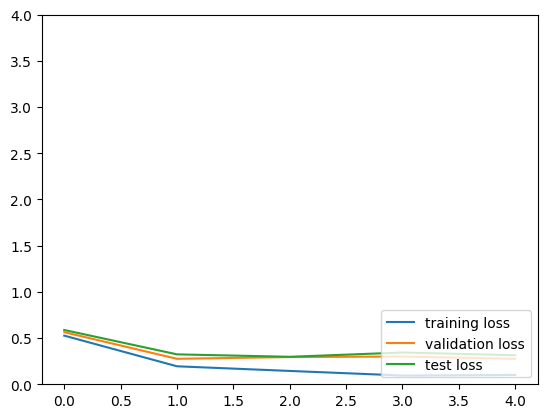

In [36]:
import matplotlib.pyplot as plt

plt.plot(train_loss, label='training loss')
plt.plot(validation_loss, label='validation loss')
plt.plot(test_loss, label='test loss')
plt.legend(loc='lower right')
plt.ylim(0,4)
plt.show()

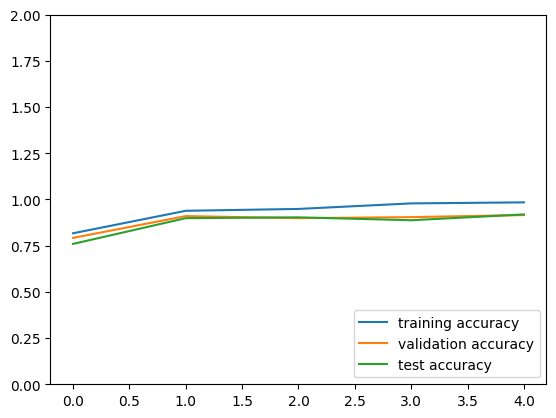

In [37]:
plt.plot(train_acc, label='training accuracy')
plt.plot(validation_acc, label='validation accuracy')
plt.plot(test_acc, label='test accuracy')
plt.legend(loc='lower right')
plt.ylim(0,2)
plt.show()